# Solution Set 6

## 1. a
Test drive / Implement A Close , Pincer Search algorithm for CFI and MFI mining and LFI mining algorithm. To the extent possible add features that depict the trace or working of each of the algorithms for user-controlled parameters such as Support, Confidence etc.

In [1]:
""" A-Close: Closed Frequent Itemsets Mining Algorithm """

from itertools import combinations

In [2]:
def generateCandidateItemsets(level_k, level_frequent_itemsets):
        """ Generate and prune the candidate itemsets for next level using the frequent itemsets of the current level
        Parameters
        ----------
        level_k : int
                The current level number
        level_frequent_itemsets : list of lists
                The list of frequent itemsets of current level
        Returns
        -------
        list of lists
                The candidate itemsets of the next level
        """

        n_frequent_itemsets = len(level_frequent_itemsets)

        candidate_frequent_itemsets = []

        for i in range(n_frequent_itemsets):
                j = i + 1
                while (j < n_frequent_itemsets) and (level_frequent_itemsets[i][:level_k - 1] == level_frequent_itemsets[j][:level_k - 1]):

                        candidate_itemset = level_frequent_itemsets[i][:level_k - 1] + [level_frequent_itemsets[i][level_k - 1]] + [level_frequent_itemsets[j][level_k - 1]]
                        candidate_itemset_pass = False

                        if level_k == 1:
                                candidate_itemset_pass = True

                        elif (level_k == 2) and (candidate_itemset[-2:] in level_frequent_itemsets):
                                candidate_itemset_pass = True

                        elif all((list(_)+candidate_itemset[-2:]) in level_frequent_itemsets for _ in combinations(candidate_itemset[:-2], level_k - 2)):
                                candidate_itemset_pass = True

                        if candidate_itemset_pass:
                                candidate_frequent_itemsets.append(candidate_itemset)

                        j += 1

        return candidate_frequent_itemsets

In [3]:
def generateClosures(transactions, generators):
        """ Generate the closures of the generators
        transactions : list of sets
                The list of transactions
        generators : lists of lists
                The list of generator itemsets whose closures need to be computed
        Returns
        -------
        list of sets
                The list of closures mapped from the generators
        """

        # The indices of transactions where generators occur
        generators_trans_indices = [[] for _ in range(len(generators))]

        for trans_index, transaction in enumerate(transactions):
                for generator_index, generator in enumerate(generators):
                        if all(_item in transaction for _item in generator):
                                generators_trans_indices[generator_index].append(trans_index)

        generators_closures = []
        for generator_trans_indices in generators_trans_indices:

                if generator_trans_indices:
                        closure = transactions[generator_trans_indices[0]].copy()

                else:
                        closure = set()

                for trans_index in generator_trans_indices[1:]:
                        closure.intersection_update(transactions[trans_index])
                generators_closures.append(closure)

        return generators_closures

In [4]:
def AClose(transactions, min_support):
        """ Extract the closed frequent itemsets from the transactions
        Returns the closed closed frequent itemsets mined from the transactions that have a support greater than the minimum
        threshold. There is one optional output in addition to the closed frequent itemsets: The support counts of the
        closed frequent itemsets mined.
        Parameters
        ----------
        transactions : list of sets
                The list of transactions
        min_support : int
                The minimum support threshold
        return_support_counts : bool, optional
                If true, also return the support count of each itemset
        Returns
        -------
        closed_frequent_itemsets : list of sets
                closed frequent itemsets mined from the transactions that have support greater than the minimum threshold
        support_counts : list of integers, optional
                The support count of the closed frequent itemsets mined. Only provided if `return_support_counts` is True.
        """

        items = set()
        for transaction in transactions:
                items.update(transaction)
        items = sorted(list(items))

        # The list of all generator from whose closure we can derive all CFIs
        generators = []

        level_k = 1

        prev_level_freq_itemsets_cnts = [] # Level 0: Frequent Itemsets and its support counts
        candidate_frequent_itemsets = [[item] for item in items] # Level 1: Candidate Itemsets

        # candidate_frequent_itemsets will be empty from as the ne
        while candidate_frequent_itemsets:

                print("LEVEL {}:".format(level_k))

                # Count the support of all candidate frequent itemsets
                candidate_freq_itemsets_cnts = [0]*len(candidate_frequent_itemsets)

                for transaction in transactions:
                        for i, itemset in enumerate(candidate_frequent_itemsets):
                                if all(_item in transaction for _item in itemset):
                                        candidate_freq_itemsets_cnts[i] += 1

                # print Candidate Itemset for current level
                print("C{}: ".format(level_k), end='')
                for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts):
                        print("{} -> {}".format(itemset, support), end=', ')
                print()

                # Generate the frequent itemsets of level k by pruning infrequent itemsets
                level_frequent_itemsets_cnts = [(itemset,support) for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support >= min_support]

                # print Frequent Itemset for current level
                print("L{}: ".format(level_k), end='')
                for itemset, support in level_frequent_itemsets_cnts:
                        print("{} -> {}".format(itemset, support), end=', ')
                print()

                # Prune the frequent itemsets of level k which have same support as some frequent subset in level k-1
                print("Itemsets Pruned from L{}: ".format(level_k), end='')
                for level_freq_itemset, level_freq_itemset_sup in level_frequent_itemsets_cnts.copy():
                        for prev_level_freq_itemset, prev_level_freq_itemset_sup in prev_level_freq_itemsets_cnts:

                                # If the previous level itemset is a subset of current level itemset and both have same support
                                if all(_item in level_freq_itemset for _item in prev_level_freq_itemset) and prev_level_freq_itemset_sup == level_freq_itemset_sup:
                                        print(level_freq_itemset, end=', ')
                                        level_frequent_itemsets_cnts.remove((level_freq_itemset, level_freq_itemset_sup))
                                        break
                print()

                # print Frequent Itemset after closure removal
                print("L{} After Pruning: ".format(level_k), end='')
                for itemset, support in level_frequent_itemsets_cnts:
                        print("{} -> {}".format(itemset, support), end=', ')
                print()

                # Generate candidate sets of level k+1 using frequent itemsets of level k
                level_frequent_itemsets = [itemset for itemset,support in level_frequent_itemsets_cnts]
                candidate_frequent_itemsets = generateCandidateItemsets(level_k, level_frequent_itemsets)
                generators.extend(level_frequent_itemsets)

                level_k += 1

                prev_level_freq_itemsets_cnts = level_frequent_itemsets_cnts
                print()

        # Generate the closure of the generators
        generators_closures = generateClosures(transactions, generators)

        closed_frequent_itemsets = []

        # Remove the duplicates from the list of closures
        for generator_closure in generators_closures:
                if generator_closure not in closed_frequent_itemsets:
                        closed_frequent_itemsets.append(generator_closure)

        # Generate count of cfi's
        closed_frequent_itemsets_cnts = [0]*len(closed_frequent_itemsets)
        for transaction in transactions:
                for i, itemset in enumerate(closed_frequent_itemsets):
                        if all(_item in transaction for _item in itemset):
                            closed_frequent_itemsets_cnts[i] += 1
        return closed_frequent_itemsets, closed_frequent_itemsets_cnts

In [5]:
""" Pincer Search: An algorithm for Maximal Frequent Itemset (MFI) mining
References:
    1. Data Mining
        - Arjun K Pujari
    2. Pincer Search: A New Algorithm for Discovering the Maximum Frequent Set
        - Dao-I-Lin, Zvi M. Kedem
"""

from itertools import combinations

In [6]:
def generateMFCS(MFCS, infrequent_itemsets):
    """ Generate the updated MFCS by modifing itemsets that have infrequent itemsets as its subset
    Parameters
    ----------
    MFCS : list of lists
        The list of Maximal Frequent Candidate Sets
    infrequent_itemsets : list of lists
        The list of infrequent itemsets
    Returns
    -------
    lists of lists
        Updated MFCS
    """

    MFCS = MFCS.copy()

    for infrequent_itemset in infrequent_itemsets:

        for MFCS_itemset in MFCS.copy():

            # If infrequent itemset is a subset of MFCS itemset
            if all(_item in MFCS_itemset for _item in infrequent_itemset):
                MFCS.remove(MFCS_itemset)

                for item in infrequent_itemset:
                    updated_MFCS_itemset = MFCS_itemset.copy()
                    updated_MFCS_itemset.remove(item)

                    if not any(all(_item in _MFCS_itemset for _item in updated_MFCS_itemset) for _MFCS_itemset in MFCS):
                        MFCS.append(updated_MFCS_itemset)

    return MFCS

In [7]:
def pruneCandidatesUsingMFS(candidate_itemsets, MFS):
    """ Prune the candidate itemsets that are subsets of MFS itemsets
    Parameters
    ----------
    candidate_itemsets : lists of lists
        The list of candidate itemsets
    MFS : lists of lists
        The list of Maximal Frequent Itemsets
    Returns
    -------
    lists of lists
        The list of candidate itemsets with are not subsets of any itemset in MFS
    """

    candidate_itemsets = candidate_itemsets.copy()

    for itemset in candidate_itemsets.copy():
        if any(all(_item in _MFS_itemset for _item in itemset) for _MFS_itemset in MFS):
            candidate_itemsets.remove(itemset)

    return candidate_itemsets

In [8]:
def generateCandidateItemsets(level_k, level_frequent_itemsets):
    """ Generate and prune the candidate itemsets for next level using the frequent itemsets of the current level 

    Parameters
    ----------
    level_k : int
        The current level number
    level_frequent_itemsets : list of lists
        The list of frequent itemsets of current level
    Returns
    -------
    list of lists
        The candidate itemsets of the next level
    """

    n_frequent_itemsets = len(level_frequent_itemsets)

    candidate_frequent_itemsets = []

    for i in range(n_frequent_itemsets):
        j = i+1
        while (j<n_frequent_itemsets) and (level_frequent_itemsets[i][:level_k-1] == level_frequent_itemsets[j][:level_k-1]):

            candidate_itemset = level_frequent_itemsets[i][:level_k-1] + [level_frequent_itemsets[i][level_k-1]] + [level_frequent_itemsets[j][level_k-1]]
            candidate_itemset_pass = False

            if level_k == 1:
                candidate_itemset_pass = True

            elif (level_k == 2) and (candidate_itemset[-2:] in level_frequent_itemsets):
                candidate_itemset_pass = True

            elif all((list(_)+candidate_itemset[-2:]) in level_frequent_itemsets for _ in combinations(candidate_itemset[:-2], level_k-2)):
                candidate_itemset_pass = True

            if candidate_itemset_pass:
                candidate_frequent_itemsets.append(candidate_itemset)

            j += 1

    return candidate_frequent_itemsets

In [9]:
def pruneCandidatesUsingMFCS(candidate_itemsets, MFCS):
    """ Prune the candidate itemsets that are not subsets of any itemsets in current MFCS 
    Parameters
    ----------
    candidate_itemsets : lists of lists
        The list of candidate itemsets
    MFCS : lists of lists
        The list of Maximal Frequent Candidate Itemsets
    Returns
    -------
    lists of lists
        The list of candidate itemsets that are subsets of some itemsets in current MFCS 
    """

    candidate_itemsets = candidate_itemsets.copy()

    for itemset in candidate_itemsets.copy():
        if not any(all(_item in _MFCS_itemset for _item in itemset) for _MFCS_itemset in MFCS):
            candidate_itemsets.remove(itemset)

    return candidate_itemsets

In [10]:
def pincerSearch(transactions, min_support):
    """ Extract the Maximal Frequent Itemsets (MFI) from the transactions 

    Parameters
    ----------
    transactions : a list of sets
        The list of transactions
    min_support : int
        The minimum support for an itemset to be considered frequent
    Returns
    -------
    list of lists
        The list of MFS which contains all maximal frequent itemsets
    """

    # Extract the list of items in the transactions
    items = set()
    for transaction in transactions:
        items.update(transaction)
    items = sorted(list(items))

    level_k = 1 # The current level number

    level_frequent_itemsets = [] # Level 0: Frequent itemsets
    candidate_frequent_itemsets = [[item] for item in items] # Level 1: Candidate itemsets
    level_infrequent_itemsets = [] # Level 0: Infrequent itemsets

    MFCS = [items.copy()] # Maximal Frequent Candidate Sets
    MFS = [] # Maximal Frequent Sets

    print("MFCS = {}".format(MFCS))
    print("MFS = {}\n".format(MFS))

    while candidate_frequent_itemsets:

        print("LEVEL {}: ".format(level_k))
        print("C{} = {}".format(level_k, candidate_frequent_itemsets))

        candidate_freq_itemsets_cnts = [0]*len(candidate_frequent_itemsets)
        MFCS_itemsets_cnts = [0]*len(MFCS)

        # Step 1: Read the database and count supports for Ck and MFCS
        for transaction in transactions:

            for i, itemset in enumerate(candidate_frequent_itemsets):
                if all(_item in transaction for _item in itemset):
                    candidate_freq_itemsets_cnts[i] += 1

            for i, itemset in enumerate(MFCS):
                if all(_item in transaction for _item in itemset):
                    MFCS_itemsets_cnts[i] += 1

        for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts):
            print("{} -> {}".format(itemset, support), end=', ')
        print()

        for itemset, support in zip(MFCS, MFCS_itemsets_cnts):
            print("{} -> {}".format(itemset, support), end=', ')
        print()

        # Step 2: MFS := MFS U {frequent itemsets in MFCS}
        MFS.extend([itemset for itemset, support in zip(MFCS, MFCS_itemsets_cnts) if ((support >= min_support) and (itemset not in MFS))])
        print("MFS = {}".format(MFS))

        # Step 3: Sk := {infrequent itemsets in Ck}
        level_frequent_itemsets = [itemset for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support >= min_support]
        level_infrequent_itemsets = [itemset for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support < min_support]

        print("L{} = {}".format(level_k, level_frequent_itemsets))
        print("S{} = {}".format(level_k, level_infrequent_itemsets))

        # Step 4: call MFCS-gen algorithm if Sk != NULL
        MFCS = generateMFCS(MFCS, level_infrequent_itemsets)
        print("MFCS = {}".format(MFCS))

        # Step 5: call MFS-pruning procedure
        level_frequent_itemsets = pruneCandidatesUsingMFS(level_frequent_itemsets, MFS)
        print("After Pruning: L{} = {}\n".format(level_k, level_frequent_itemsets))

        # Step 6: Generate candidates Ck+1 from Ck (using generate and prune)
        candidate_frequent_itemsets = generateCandidateItemsets(level_k, level_frequent_itemsets)

        # Step 7: If any frequents itemsets in Ck is removed in MFS-pruning procedure
        # Call the recovery procedure to recover candidates to Ck+1

        # Step 8: call MFCS-prune procedure to prune candidates in Ck+1
        candidate_frequent_itemsets = pruneCandidatesUsingMFCS(candidate_frequent_itemsets, MFCS)

        # Step 9: k := k+1
        level_k += 1

    return MFS

## 1. b
Test drive or implement any one algorithm each for CFI, MFI which has not been discussed in the class (Other than A-close and Pincer). You are free to use any open-source available versions (eg. FIMI website etc.)

In [11]:
import numpy as np
import itertools 
import copy

In [12]:
def CHARM(item, Data, min_sup):
    nodes = []
    CFI = []
    t = set()
    for i in range(len(item)):
        t = set()
        for j in range(len(Data)):
            if Data[j][i]==1:
                t = t.union({j})
        if len(t)>=min_sup:
            nodes.append([{item[i]},t])
    nodes.sort(key = lambda x: len(x[1]))
    CHARM_EXTEND(nodes, CFI, min_sup)
    return(CFI)

In [13]:
def CHARM_EXTEND(nodes, CFI, min_sup):
    for item in nodes:
        new_nodes = []
        X = item
        for item_ in nodes: 
            if len(item[1]) > len(item_[1]) :
                X = [item[0].union(item_[0]), item[1].intersection(item_[1])]
                CHARM_PROPERTY(nodes, new_nodes, X, item, item_, min_sup)
        if new_nodes != []:
            new_nodes.sort(key = lambda x: len(x[1])) 
            CHARM_EXTEND(new_nodes, CFI, min_sup)
        if X not in CFI :
            CFI.append(X)
    return(CFI)

In [14]:
def CHARM_PROPERTY(nodes, new_nodes, X, item, item_, min_sup):
    if len(X[1]) >= min_sup:
        if item[1] == item_[1]:
            nodes.remove(item_)
            for i in range(len(nodes)):
                if nodes[i] == item:
                    nodes[i] == X
        elif item[1].issubset(item_[1]):
            for i in range(len(nodes)):
                if nodes[i] == item:
                    nodes[i] == X
        elif item_[1].issubset(item[1]):
            nodes.remove(item_)
            new_nodes.append(X)
        elif item[1] != item_[1]:
            new_nodes.append(X)

In [15]:
""" MAFIA: A Maximal Frequent Itemset Algorithm
Reference: 
    MAFIA: A Maximal Frequent Itemset Algorithm for Transactional Databases
        - Doug Burdick, Manuel Calimlin, Johannes Gehrke (Department of CS, Cornell University)
"""

import numpy as np
from functools import lru_cache

In [16]:
class TransVerticalBitmaps:
    """ Stores transactions as vertical bitmap of individual items and helps count itemset supports efficiently 
    Parameters
    ----------
    transactions : list of sets
        The list of transactions
    Attributes
    ----------
    transactions : list of sets
        The list of transactions
    n_transactions : int
        The number of transactions
    items : list
        The list of all items in sorted order
    items_vertical_bitmaps : dict
        The dictionary of vertical bitmap representation of transactions indexed by item
    """

    def __init__(self, transactions):

        self.transactions = transactions
        self.n_transactions = len(self.transactions)

        # Extract the list of items in the transactions
        items = set()
        for transaction in self.transactions:
            items.update(transaction)
        self.items = sorted(items)

        self.items_vertical_bitmaps = {item:np.zeros(shape=(self.n_transactions, ), dtype=np.bool) for item in self.items}

        for i_transaction, transaction in enumerate(self.transactions):
            for item in transaction:
                self.items_vertical_bitmaps[item][i_transaction] = True


    @lru_cache(maxsize = 32)
    def compVerticalBitmap(self, itemset):
        """ Compute the vertical bitmap of the given itemset

        Parameters
        ----------
        itemset : tuple
            The tuple of items (or itemset) for which support is to be counted
        Returns
        -------
        np.array(bool)
            Vertical bitmap of transactions in the which itemset is present
        """

        if len(itemset) == 1:
            item = itemset[0]
            return self.items_vertical_bitmaps[item]

        else:
            last_item = itemset[-1]
            return self.compVerticalBitmap(itemset[:-1])&self.items_vertical_bitmaps[last_item]


    def countSupport(self, itemset):
        """ Count the support of the itemset in the transactions 
        Parameters
        ----------
        itemset : tuple
            The tuple of items for which support is to be counted
        Returns
        -------
        int
            The support count of the itemset in the transactions
        """

        itemset_vertical_bitmap = self.compVerticalBitmap(itemset)
        itemset_support_count = np.count_nonzero(itemset_vertical_bitmap)

        return itemset_support_count

In [17]:
class MafiaNode:
    """ A node in the MAFIA candidate itemset tree 

    Parameters
    ----------
    head : set
        The set of all items in head of the node
    tail : tuple
        The tuple of all items in tail of the node
    support_count : int optional(default=None)
        The support count of head of the node
    Attributes
    ----------
    head : set
        The set of all items in head of the node
    tail : tuple
        The tuple of all items in tail of the node
    support_count : int
        The support count of head of the node
    Notes
    -----
        The :attr:`head` is of type tuple as opposed to set or list since it is passed to :meth:`compVerticalBitmap`
        of :class:`transactions` that caches results and therefore requires the inputs to **hashable**.
    """

    def __init__(self, head, tail, support_count=None):
        self.head = head
        self.tail = tail.copy()
        self.support_count = support_count


In [18]:
def _mafiaAlgorithm(current_node, MFIs, transactions, min_support_count):

    # HUTMFI Pruning - Prune the subtree, if the HUT of the node has any superset in MFI
    head_union_tail = current_node.head + tuple(current_node.tail)
    if any(all(item in mfi for item in head_union_tail) for mfi in MFIs):
        return

    # Count the support of all children of the node
    node_children_support_cnts = [( item ,transactions.countSupport(current_node.head + (item,)) ) for item in current_node.tail]
    # Extract the frequent children of the node and their support counts
    node_freq_children_sup_cnts = [(item, support_count) for item, support_count in node_children_support_cnts if support_count >= min_support_count]

    node_children_items_parent_eq = [] # The items in tail with same support as parent
    node_tail_items_sup_cnts = [] # The items in node's tail (except parent equivalence items) sorted by desc support

    for item, support_count in node_freq_children_sup_cnts:
        if support_count == current_node.support_count:
            node_children_items_parent_eq.append(item)
        else:
            node_tail_items_sup_cnts.append((item, support_count))

    # Sort the items in the trimmed tail by increasing support
    node_tail_items_sup_cnts.sort(key=lambda x : x[1])
    node_tail_items = [item for item, support in node_tail_items_sup_cnts]

    current_node.head += tuple(node_children_items_parent_eq)
    current_node.tail = node_tail_items

    is_leaf = not bool(current_node.tail)

    for i, item in enumerate(current_node.tail):
        new_node_head = current_node.head + (item,)
        new_node_tail = current_node.tail[i + 1:]
        new_node_support_cnt = node_tail_items_sup_cnts[i][1]
        new_node = MafiaNode(new_node_head, new_node_tail, new_node_support_cnt)

        is_hut = (i == 0) # if i is the first element in the tail
        _mafiaAlgorithm(new_node, MFIs, transactions, min_support_count)

    # if current node is a leaf and no superset of current node head in MFIs
    if is_leaf and current_node.head and not any(all(item in mfi for item in current_node.head) for mfi in MFIs):
        MFIs.append(set(current_node.head))

In [19]:
def mafiaAlgorithm(transactions, min_support_count):
    """ Extract the MFIs (Maximal Frequent Itemsets) from transactions with min support count using MAFIA Algorithm
    Parameters
    ----------
    transactions : list of sets
        The list of transactions
    min_support_count : int
        The minimum support count threshold
    Returns
    -------
    list of sets
        The list of all maximal frequent itemsets
    """

    transactions_vertical_bitmaps = TransVerticalBitmaps(transactions)
    MFIs = []

    # Create the root node of MAFIA candidate itemset tree
    mafia_cand_itemset_root = MafiaNode(tuple(), transactions_vertical_bitmaps.items, transactions_vertical_bitmaps.n_transactions)

    # Perform the MAFIA algorithm
    _mafiaAlgorithm(mafia_cand_itemset_root, MFIs, transactions_vertical_bitmaps, min_support_count)
    return MFIs

In [20]:
transactions = [
    {1, 5, 6, 8},
    {2, 4, 8},
    {4, 5, 7},
    {2, 3},
    {5, 6, 7},
    {2, 3, 4},
    {2, 6, 7, 9},
    {5},
    {8},
    {3, 5, 7},
    {3, 5, 7},
    {5, 6, 8},
    {2, 4, 6, 7},
    {1, 3, 5, 7},
    {2, 3, 9},
]

min_support_count = 3

In [21]:
MFS = pincerSearch(transactions, min_support_count)
print("Maximal Frequent Set = {}".format(MFS))

MFCS = [[1, 2, 3, 4, 5, 6, 7, 8, 9]]
MFS = []

LEVEL 1: 
C1 = [[1], [2], [3], [4], [5], [6], [7], [8], [9]]
[1] -> 2, [2] -> 6, [3] -> 6, [4] -> 4, [5] -> 8, [6] -> 5, [7] -> 7, [8] -> 4, [9] -> 2, 
[1, 2, 3, 4, 5, 6, 7, 8, 9] -> 0, 
MFS = []
L1 = [[2], [3], [4], [5], [6], [7], [8]]
S1 = [[1], [9]]
MFCS = [[2, 3, 4, 5, 6, 7, 8]]
After Pruning: L1 = [[2], [3], [4], [5], [6], [7], [8]]

LEVEL 2: 
C2 = [[2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [4, 5], [4, 6], [4, 7], [4, 8], [5, 6], [5, 7], [5, 8], [6, 7], [6, 8], [7, 8]]
[2, 3] -> 3, [2, 4] -> 3, [2, 5] -> 0, [2, 6] -> 2, [2, 7] -> 2, [2, 8] -> 1, [3, 4] -> 1, [3, 5] -> 3, [3, 6] -> 0, [3, 7] -> 3, [3, 8] -> 0, [4, 5] -> 1, [4, 6] -> 1, [4, 7] -> 2, [4, 8] -> 1, [5, 6] -> 3, [5, 7] -> 5, [5, 8] -> 2, [6, 7] -> 3, [6, 8] -> 2, [7, 8] -> 0, 
[2, 3, 4, 5, 6, 7, 8] -> 0, 
MFS = []
L2 = [[2, 3], [2, 4], [3, 5], [3, 7], [5, 6], [5, 7], [6, 7]]
S2 = [[2, 5], [2, 6], [2, 7], [2, 8], [3, 4], [3, 6], 

In [22]:
CFIs, CFI_cnts = AClose(transactions, min_support_count)

print("Closed Frequent Itemsets (CFIs)")
print("-------------------------------")
for itemset, cnt in zip(CFIs, CFI_cnts):
    print("Itemset: {} Support count: {}".format(itemset, cnt))

LEVEL 1:
C1: [1] -> 2, [2] -> 6, [3] -> 6, [4] -> 4, [5] -> 8, [6] -> 5, [7] -> 7, [8] -> 4, [9] -> 2, 
L1: [2] -> 6, [3] -> 6, [4] -> 4, [5] -> 8, [6] -> 5, [7] -> 7, [8] -> 4, 
Itemsets Pruned from L1: 
L1 After Pruning: [2] -> 6, [3] -> 6, [4] -> 4, [5] -> 8, [6] -> 5, [7] -> 7, [8] -> 4, 

LEVEL 2:
C2: [2, 3] -> 3, [2, 4] -> 3, [2, 5] -> 0, [2, 6] -> 2, [2, 7] -> 2, [2, 8] -> 1, [3, 4] -> 1, [3, 5] -> 3, [3, 6] -> 0, [3, 7] -> 3, [3, 8] -> 0, [4, 5] -> 1, [4, 6] -> 1, [4, 7] -> 2, [4, 8] -> 1, [5, 6] -> 3, [5, 7] -> 5, [5, 8] -> 2, [6, 7] -> 3, [6, 8] -> 2, [7, 8] -> 0, 
L2: [2, 3] -> 3, [2, 4] -> 3, [3, 5] -> 3, [3, 7] -> 3, [5, 6] -> 3, [5, 7] -> 5, [6, 7] -> 3, 
Itemsets Pruned from L2: 
L2 After Pruning: [2, 3] -> 3, [2, 4] -> 3, [3, 5] -> 3, [3, 7] -> 3, [5, 6] -> 3, [5, 7] -> 5, [6, 7] -> 3, 

LEVEL 3:
C3: [3, 5, 7] -> 3, [5, 6, 7] -> 1, 
L3: [3, 5, 7] -> 3, 
Itemsets Pruned from L3: [3, 5, 7], 
L3 After Pruning: 

Closed Frequent Itemsets (CFIs)
-----------------------------

In [23]:
MFIs = mafiaAlgorithm(transactions, min_support_count)
# Print the list of all maximal frequent itemsets (MFIs)
print("Maximal Frequent Itemsets (MFIs)")
for mfi in MFIs:
    print(mfi)

Maximal Frequent Itemsets (MFIs)
{2, 4}
{8}
{6, 7}
{5, 6}
{2, 3}
{3, 5, 7}


In [24]:
Data = [[1, 1, 0],[1, 0, 0],[0, 1, 1],[0, 0, 0]]
unique_itemset = [1, 2, 3]
min_sup = 1

print(CHARM(unique_itemset, Data, min_sup))

[[{3}, {2}], [{1, 3}, set()], [{2, 3}, {2}]]


### NOTE
***The above is taken from a github [repo](https://github.com/guptaanmol184/big-data-lab)*** 

## 2
Understand the working of the following classifier algorithms and trace the same for a sample dataset (min 10 records) which involves 2 classes (Binary Classifier) eg: 'Yes' or 'No' , 'True' or 'False'.

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [26]:
clf = DecisionTreeClassifier(random_state= 0)
iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


1. Decision Tree Induction
    - Give pseudo code and trace decision tree algorithms.
    - Understand attribute selection measures such as Information gain, gain ratio (use anyone for the trace).

### PseudoCode- Decision Tree

<pre><code>

GenDecTree(SampIe S, Features F)
Steps:
1. If stopping_condition(S, F) = true then
    a. Leaf = createNode()
    b. leafLabeI = classify(s)
    c. return leaf
2. root = createNode()
3. root.test_condition =findBestSpilt(S,F)
4. V = {v I v a possible outcomecfroot.test_condition}
5. For each value v C V:
    a. Sv {s I root. test_condition(s) = vandsCS};
    b. Child = Treec;rowth (Sv,F);
    c. Add child as descent of root and label the edge {root —9
child} as v
6. return root
</code> </pre>

In [27]:
clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0, criterion= 'gini')
clf.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

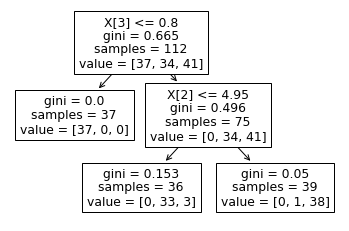

In [28]:
tree.plot_tree(clf)
plt.show()

[Decision Tree reference](https://openi.nlm.nih.gov/detailedresult?img=PMC3507711_1472-6947-12-131-1&req=4)

2. Naive Bayesian Classifier (NBC)
    - Read about Bayes theorem, conditional class independence, prior and posterior probabilities.
    - How to handle zero probability scenario (Laplacian Estimator)
    - Give a short pseudo code and trace.

### PseudoCode- Naive Bayesian Classifier
<pre><code>
<b>Input</b>
F = (f1, f2, f3, ..., fn)
F = Predictor Value for test dataset
Training Data = D

<b>Output</b>
A class for testing dataset

<b>Step</b>
1. Read D
2. Calculate mean and std. dev for each predictor in each class
3. Repeat {
    Ci = ith class 
    and 
    X is some training record row from D
    P(X | Ci) = P(x1 | Ci) * P(x2 | Ci) * ... * P(xn | Ci)
    xk are the attributes in the class record of D
    P(xk | Ci) = Count of xk in the Class Ci / Total records in class Ci
}
4. Calculate the likelihood for each record and select the max
    Calculate probablity density for each fi using the equation
    P(Ci | X) = P(X | Ci) * P(Ci) / P(X) 
    P(Ci) = 1 / No of classes
    but P(X) is common in all classes and hence can be ignored as we this only for comparision
5. return the class that give max likelihood

<b> end </b>

</code></pre>

In [29]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [30]:
y_pred = classifier.predict(X_test) 
y_pred

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1])

In [31]:
cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import accuracy_score 
print ("Accuracy : ", accuracy_score(y_test, y_pred))
cm

Accuracy :  1.0


array([[13,  0,  0],
       [ 0, 16,  0],
       [ 0,  0,  9]])

In [35]:
y_test == y_pred

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

[Naive Bayesian Classifier Reference](https://towardsdatascience.com/machine-learning-basics-naive-bayes-classification-964af6f2a965)